# Assignment 3: Metaheuristics

In [1]:
# import libaries
import numpy as np
import pandas as pd
import math
import random
import time
import itertools
from IPython.display import display, HTML
import ipywidgets as widgets
import matplotlib.pyplot as plt
from matplotlib import cm
from ipywidgets import GridBox, Layout

In [2]:
# Import custom functions
# These functions are assumed to be defined in the respective modules

# The distance_function module contains two functions:
# 1. 'compute_distance_matrix' which computes the distance matrix from either 
# a set of coordinates or a precomputed distance matrix depending on the mode 
# ("Coordinates" or "DistanceMatrix").
# 2. 'get_coordinates' which returns the coordinates of the cities 
from distance_function import (compute_distance_matrix,
                                         get_coordinates)

# The tour_initializations module contains three functions for initializing the tour:
# 1. compute_nearest_neighbor_tour: initializes the tour by always moving to the nearest neighbor
# 2. compute_successive_insertion_tour: initializes the tour by successively inserting the cities 
#    in a way that minimizes the increase in total tour length
# 3. compute_random_tour: initializes the tour randomly
from tour_initializations import (
    compute_nearest_neighbor_tour, 
    compute_successive_insertion_tour, 
    compute_random_tour
)


### Exercise 1: Setting Simulated Annealing Parameters for the TSP

#### a)

###### !!! In the function simulated_annealing_doe there is the annealing part missing. Code this part yourself at the position of the placeholder!!!

In [3]:
def simulated_annealing_doe(distance,tour, length, init_temperature, threshold, iterations, cooling_parameter, neighborhood, termination):
    '''
    Function to perform the simulated annealing process.
    Stopping Criterion: The annealing process stops when the maximum number of steps (hyperparameter) is reached

    Parameters:
    tour (list): The initial tour.
    length (float): The total length of the initial tour.
    init_temperature (float): The initial temperature for the simulated annealing process.
    steps (int): The maximum number of steps for the annealing process.
    iterations (int): The number of iterations within each step.
    cooling_parameter (float): The cooling parameter for the simulated annealing process.
    neighborhood (str): The neighborhood search strategy ('2-opt' or 'exchange').

    Returns:
    best_tour (list): The best tour found during the annealing process.
    best_length (float): The total length of the best tour found.
    '''

    best_length = length  # Initialize the best solution found so far
    best_tour = tour  # Initialize the best tour found so far
    num_cities=len(tour)-1 # The number of cities in the tour.
    tour_history = [tour]
    length_history = [length]
    temperature_history = [init_temperature]
    best_step=0

    # Perform the simulated annealing process
    temperature=init_temperature
    
    if termination== 'max_steps':
        steps_until_threshold=0
        for s in range(threshold):
            
            '''
            # STUDENT CODE STARTS HERE:
            # 1. Implement the logic to carry out iterations for the simulated annealing process.
            #    -This includes deciding whether to accept a new tour based on the delta (for 2-opt and exchange depending on the neighborhood hyperparameter) and the current temperature.
            #    -Update the tour, length (for 2-opt and exchange depending on the neighborhood hyperparameter) and best_length based on the acceptance criterion.
            #    -Finally, it should return the updated tour, length, and best_length.
            # 2. Append the current tour, length, and temperature to the respective history lists.
            # 3. Update the temperature using the cooling_parameter.
            # STUDENT CODE ENDS HERE.
            '''

            def simulated_annealing_iterations(distance, tour,iterations,num_cities,neighborhood,temperature,length,best_tour,best_length,step,best_step):
                for m in range(iterations):
                    i = random.randrange(num_cities - 2)
                    j = random.randrange(i + 2, num_cities)

                    if neighborhood == '2-opt':
                        delta = calculate_delta_with_2opt(distance, tour, i, j)
                    elif neighborhood == 'exchange':
                        delta = calculate_delta_with_exchange(distance, tour, i, j)
                    else:
                        raise ValueError(f"Unknown neighborhood search strategy {neighborhood}")

                    if delta > 0 or (random.random() < math.exp(delta / temperature)):
                        if neighborhood == '2-opt':
                            tour, length = update_tour_with_2opt(tour, i, j, distance)
                        elif neighborhood == 'exchange':
                            tour, length = update_tour_with_exchange(tour, i, j, distance)
                        else:
                            raise ValueError(f"Unknown neighborhood search strategy {neighborhood}")

                    if length < best_length:
                        best_length = length
                        best_tour = tour
                        best_step=step+1

                return tour,length,best_tour,best_length,best_step

            def calculate_delta_with_2opt(distance, tour, i, j):
                delta = distance[tour[i], tour[i + 1]] + distance[tour[j], tour[j + 1]] - distance[tour[i], tour[j]] - distance[tour[i + 1], tour[j + 1]]
                for k in range(j - i - 1):
                    delta = delta + distance[tour[j - k - 1], tour[j - k]] - distance[tour[j - k], tour[j - k - 1]]  
                return delta

            def calculate_delta_with_exchange(distance, tour, i, j):
                old_length=calculate_tour_length(tour, distance)
                tour_new, new_length=update_tour_with_exchange(tour, i, j, distance)
                delta = old_length - new_length
                return delta

            def update_tour_with_2opt(tour, i, j, distance):
                tour_new = tour[:i + 1] + tour[j:i:-1] + tour[j + 1:]
                length_new = calculate_tour_length(tour_new, distance)
                return tour_new, length_new

            def update_tour_with_exchange(tour, i, j, distance):
                tour_new = tour.copy()
                tour_new[i], tour_new[j] = tour[j], tour[i]
                length_new = calculate_tour_length(tour_new, distance)
                return tour_new, length_new

            def calculate_tour_length(tour, distance):
                length = 0.0
                for i in range(len(tour) - 1):
                    length += distance[tour[i], tour[i + 1]]
                return length

            tour,length,best_tour,best_length,best_step=simulated_annealing_iterations(distance, tour,iterations,num_cities,neighborhood,temperature,length,best_tour,best_length,s,best_step)
            tour_history.append(tour.copy())
            length_history.append(length)
            temperature_history.append(temperature)
            temperature = cooling_parameter * temperature  
            steps_until_threshold=steps_until_threshold+1
            
    # Return the best tour and length, and the history
    return best_tour, best_length, tour_history, length_history,temperature_history,steps_until_threshold,best_step


##### Set parameters and perform Grid Search


In [4]:
# Set parameters

# The path to the data file
PATH = 'gr120.xlsx'

# MODE can be "DistanceMatrix" or "Coordinates" depending on whether your data is a distance matrix 
# or a set of geographical coordinates, respectively.
MODE = "DistanceMatrix"


# INIT specifies the method for generating the initial tour. Options are:
# "nearest_neighbor" - selects the next city that is the nearest unvisited neighbor
# "successive_insertion" - selects the next city that results in the least increase in tour length
# "random" - selects the next city randomly


# NEIGHBORHOOD specifies the neighborhood search strategy. Options are:
# "2-opt" - repeatedly removes two edges and replaces them in a way that reduces the tour length
# "exchange" - swaps the positions of two cities in the tour

"""
parameters = {'termination' : ['max_steps'],  # max_steps, min_temp
              'threshold': [50, 100],  # ! only one value allowed if termination == min_temp
              'alpha': [0.2,0.1],
              'iterations': [100, 250],
              'cooling': [0.5,0.7],
              'INIT':['nearest_neighbor','successive_insertion','random'],
              'NEIGHBORHOOD':['2-opt','exchange'],} 
"""
parameters = {'termination' : ['max_steps'],  # max_steps, min_temp
              'threshold': [50,100],  # ! only one value allowed if termination == min_temp
              'alpha': [0.2,0.1,0.05],
              'iterations': [100,1000,10000],
              'cooling': [0.5,0.7,0.95],
              'INIT':['nearest_neighbor','successive_insertion','random'],
              'NEIGHBORHOOD':['2-opt','exchange'],} 
# The code will compute the tour and its length for all possible combinations of parameters given in the 'parameters' dictionary.
# Each parameter will take on its possible values, resulting in a set of unique parameter combinations.
# The number of tours will be equal to the product of the number of possible values for each parameter.
# The tour and its length will be computed for each parameter combination using the defined algorithm.




# Compute the distance matrix
distance = compute_distance_matrix(MODE, PATH)

# Get the number of cities
num_cities = len(distance)

# Generate all combinations of parameter values
param_values = list(itertools.product(*parameters.values()))

performance_dict = {}
N = len(param_values)
n = 0

# The Grid Search about 30 min to run (depending on computer)
for values in param_values:
    # Convert the tuple of values to a dictionary
    params_dict = {k: v for k, v in zip(parameters.keys(), values)}

    params_str = ', '.join(f'{k}:{v}' for k, v in params_dict.items())
    print(f"{n+1}/{N}  -  {params_str}")
    print(params_str)

    # Choose the initial tour generation method based on the INIT parameter
    if params_dict['INIT'] == 'nearest_neighbor':
        tour, length = compute_nearest_neighbor_tour(distance, num_cities)
    elif params_dict['INIT'] == 'successive_insertion':
        tour, length = compute_successive_insertion_tour(distance, num_cities)
    elif params_dict['INIT'] == 'random':
        tour, length = compute_random_tour(distance, num_cities)
    else:
        raise ValueError(f"Unknown initialization method {params_dict['INIT']}")
    
    init_tour = tour 
    init_length = length
    
    start = time.time()
    best_tour, best_tour_length, tour_history, length_history,temperature_history,steps_until_threshold,best_step = simulated_annealing_doe(distance, tour, length, length*params_dict['alpha'], params_dict['threshold'], params_dict['iterations'], params_dict['cooling'], params_dict['NEIGHBORHOOD'],params_dict['termination'])
    end = time.time()
    
    # Store all the parameters and results in the dictionary
    performance_dict[n] = {**params_dict, 'steps_to_threshold':steps_until_threshold, 'final_temperature':temperature_history[-1], 'best_tour_length': best_tour_length, 'time': round(end - start, 4), 'best_tour': best_tour, 'tour_history': tour_history, 'length_history': length_history,'temperature_history': temperature_history, 'best_step':best_step }
    
    n += 1
    if (n + 1) < 10:
        print(f"         Time: {round(end - start, 4)} s")
    else:
        print(f"          Time: {round(end - start, 4)} s")


1/324  -  termination:max_steps, threshold:50, alpha:0.2, iterations:100, cooling:0.5, INIT:nearest_neighbor, NEIGHBORHOOD:2-opt
termination:max_steps, threshold:50, alpha:0.2, iterations:100, cooling:0.5, INIT:nearest_neighbor, NEIGHBORHOOD:2-opt
         Time: 0.3115 s
2/324  -  termination:max_steps, threshold:50, alpha:0.2, iterations:100, cooling:0.5, INIT:nearest_neighbor, NEIGHBORHOOD:exchange
termination:max_steps, threshold:50, alpha:0.2, iterations:100, cooling:0.5, INIT:nearest_neighbor, NEIGHBORHOOD:exchange
         Time: 0.4545 s
3/324  -  termination:max_steps, threshold:50, alpha:0.2, iterations:100, cooling:0.5, INIT:successive_insertion, NEIGHBORHOOD:2-opt
termination:max_steps, threshold:50, alpha:0.2, iterations:100, cooling:0.5, INIT:successive_insertion, NEIGHBORHOOD:2-opt
         Time: 0.1465 s
4/324  -  termination:max_steps, threshold:50, alpha:0.2, iterations:100, cooling:0.5, INIT:successive_insertion, NEIGHBORHOOD:exchange
termination:max_steps, threshold:5

##### Create table

In [5]:
# Please insert your code here
def pretty_print(df):
    return display(HTML(df.to_html().replace("\\n","<br>")))

performance_dict_short = {}
for key, value in performance_dict.items():
    performance_dict_short[key] = {k: v for k, v in value.items() if k not in ['best_tour', 'tour_history', 'length_history','temperature_history']}
summary_performance = pd.DataFrame.from_dict(performance_dict_short, orient='index')
summary_performance.rename(columns={'best_tour_length': 'Objective', 'time': 'Time [s]'}, inplace=True)

# Apply styling to DataFrame
styled = summary_performance.style.set_properties(**{'background-color': 'black',
                                                    'color': 'lawngreen',
                                                    'border-color': 'white'})

pretty_print(styled)

,termination,threshold,alpha,iterations,cooling,INIT,NEIGHBORHOOD,steps_to_threshold,final_temperature,Objective,Time [s],best_step
0,max_steps,50,0.200000,100,0.500000,nearest_neighbor,2-opt,50,0.000000,9351.000000,0.311500,0
1,max_steps,50,0.200000,100,0.500000,nearest_neighbor,exchange,50,0.000000,9351.000000,0.454500,0
2,max_steps,50,0.200000,100,0.500000,successive_insertion,2-opt,50,0.000000,7779.000000,0.146500,0
3,max_steps,50,0.200000,100,0.500000,successive_insertion,exchange,50,0.000000,7779.000000,0.462800,0
4,max_steps,50,0.200000,100,0.500000,random,2-opt,50,0.000000,10325.000000,0.168200,50
5,max_steps,50,0.200000,100,0.500000,random,exchange,50,0.000000,18361.000000,0.516900,50
6,max_steps,50,0.200000,100,0.700000,nearest_neighbor,2-opt,50,0.000048,9351.000000,0.153600,0
7,max_steps,50,0.200000,100,0.700000,nearest_neighbor,exchange,50,0.000048,9351.000000,0.442200,0
8,max_steps,50,0.200000,100,0.700000,successive_insertion,2-opt,50,0.000040,7779.000000,0.184600,0
9,max_steps,50,0.200000,100,0.700000,successive_insertion,exchange,50,0.000040,7779.000000,0.975700,0


##### Find best hyperparameters

In [6]:
# Please insert your code here
best_tour_length = None
best_hyperparameters = None
for hyperparameters in performance_dict_short.values():
  if best_tour_length is None or hyperparameters['best_tour_length'] < best_tour_length:
    best_hyperparameters = hyperparameters
    best_tour_length = hyperparameters['best_tour_length']
print(best_tour_length)
print(best_hyperparameters)
selects = best_hyperparameters

6962.0
{'termination': 'max_steps', 'threshold': 100, 'alpha': 0.05, 'iterations': 10000, 'cooling': 0.95, 'INIT': 'nearest_neighbor', 'NEIGHBORHOOD': '2-opt', 'steps_to_threshold': 100, 'final_temperature': 2.9138351968075358, 'best_tour_length': 6962.0, 'time': 32.4983, 'best_step': 96}


##### Interactive Code to play with the hyperparameters

In [7]:
def plot_tours(N, step, max_steps_dict, **kwargs):
    '''
    Plots the TSP tours and the tour length as a function of the step.

    Inputs:
    - N (int): The total number of tours.
    - step (int): The current step for which the tour is being plotted.
    - max_steps_dict (dict): A dictionary mapping parameter set indices to their respective maximum number of steps.
    - **kwargs: Parameters which define a particular tour.

    Outputs:
    - Two plots: one visualizing the tour path and the other displaying the tour length over time.
    '''    
    # Calculate tour_index from parameter values
    tour_index =  get_index_from_parameters(kwargs)

    # Get the maximum number of steps for the current parameter set
    max_steps = max_steps_dict[tour_index]
    
    # Calculate tour_index from parameter values
    tour_index = tour_index = get_index_from_parameters(kwargs)

    fig, ax = plt.subplots(figsize=(8, 8))

    # Plot all cities
    ax.scatter(coordinates[:, 0], coordinates[:, 1], color='black', s=10)

    # Annotate the city numbers
    for i, txt in enumerate(coordinates):
        ax.annotate(i, (coordinates[i, 0], coordinates[i, 1]), fontsize=8, ha='right')

    # Define a color map
    colors = plt.cm.get_cmap('rainbow', N)

    # Plot tours
    tour_history = performance_dict[tour_index]['tour_history']
    if step < max_steps: #len(tour_history):  # Check if the step is within the history length
        tour = tour_history[step]
        tour_coords = coordinates[tour]
        tour_coords = np.vstack((tour_coords, tour_coords[0]))  # Close the tour
        color = colors(tour_index)
        ax.plot(tour_coords[:, 0], tour_coords[:, 1], color=color)
        # Save the color of the plotted tour
        #color_dict[tour_index] = color

    # Add parameters and tour length as labels in the plot
    ax.text(0.01, 0.98, f'tour length at step {step}/{max_steps-1}: {performance_dict[tour_index]["length_history"][step]}', transform=ax.transAxes, fontsize=8, va='top', ha='left')
    ax.text(0.01, 0.98-0.025, f'temperature at step {step}/{max_steps-1}: {round(performance_dict[tour_index]["temperature_history"][step],5)}', transform=ax.transAxes, fontsize=8, va='top', ha='left')
    for i, (k, v) in enumerate(kwargs.items()):
        if k == "steps":
            continue  # Skip 'steps' because it's already in the tour length label
        ax.text(0.01, 0.98-(i+2)*0.025, f'{k}: {v}', transform=ax.transAxes, fontsize=8, va='top', ha='left')

    ax.grid(True)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title('TSP Tours', fontsize=16)
    plt.show()
    
    best_step = performance_dict[tour_index]['best_step']
    tour_lengths = performance_dict[tour_index]['length_history']
    
    print('Best tour length: '+ str(min(tour_lengths)))
    print('Step:             '+ str(best_step))
    print('Best tour       : ', tour )
          
    
    
    # Plot the tour length as a function of step
    plt.figure(figsize=(8, 4))
    tour_lengths = performance_dict[tour_index]['length_history']
    plt.plot(tour_lengths, '-',color=colors(tour_index))  # +1 because the slice excludes the last index

    # Annotate initial and final distances
    initial_distance = tour_lengths[0]
    final_distance = tour_lengths[-1]

    plt.annotate(f'{initial_distance}', (0, initial_distance), 
                 textcoords="offset points", xytext=(-5,10), ha='center',color='k')
    plt.annotate(f' {final_distance}', (len(tour_lengths)-1, final_distance), 
                 textcoords="offset points", xytext=(-10,10), ha='center',color='k')

    plt.xlabel('Step')
    plt.ylabel('Tour length')
    plt.ylim(0,1.05*max(max(value['length_history']) for value in performance_dict.values()))
    plt.title('Tour length as a function of step')
    plt.grid(True)
    plt.show()
    
    
    
    # Plot the temperature as a function of step
    plt.figure(figsize=(8, 4))
    temp_history = performance_dict[tour_index]['temperature_history']
    plt.plot(temp_history[1:], '-',color=colors(tour_index))  # +1 because the slice excludes the last index

    # Annotate initial and final distances
    initial_temp = temp_history[0]
    final_temp = temp_history[-1]

   # plt.annotate(f'{initial_temp}', (0, initial_temp), 
    #             textcoords="offset points", xytext=(-5,10), ha='center',color='k')
    #plt.annotate(f' {final_temp}', (len(temp_history)-1, final_temp), 
    #             textcoords="offset points", xytext=(-10,10), ha='center',color='k')

    plt.xlabel('Step')
    plt.ylabel('Temperature')
    #plt.ylim(0,1.05*max(temp_history[0]))
    plt.title('Temperature as a function of step')
    plt.grid(True)
    plt.show()
    
    
# Create a callback function to update the 'step' Slider widget
def update_step_range(*args):
    """
    Callback function to update the maximum value of the 'step' Slider widget based on the selected value of the 'steps' Select widget.

    Inputs:
    - *args: Variable length argument list.

    Returns:
    - None
    """
    selects['step'].max = selects['steps'].value - 1

In [8]:
def get_tour_colors(max_steps):
    N =max_steps   # Number of tours
    colors = plt.cm.get_cmap('rainbow', N)  # Color map

    color_dict = {}
    for tour_index in range(N):
        color = colors(tour_index)  # Get color
        color_dict[tour_index] = color  # Store color

    return color_dict

# Define a dictionary to store the maximum number of steps for each parameter set
max_steps_dict = {}

# Load coordinates
coordinates = get_coordinates(PATH)

# Define parameters and their possible values
weights = np.cumprod([1] + [len(v) for v in list(parameters.values())[:-1]])

# Define a color map
colors = plt.cm.get_cmap('rainbow', N)

# Create Select widgets for selecting parameters
param_selects = {k: widgets.Select(options=v, description=k) for k, v in parameters.items()}

# Find the maximum steps from performance_dict
max_steps_total = max(record['steps_to_threshold'] for record in performance_dict.values())
color_dict=get_tour_colors(N)

# Add a slider for the steps
step_slider = widgets.IntSlider(min=0, max=max_steps_total, description='step')

# Combine all widgets
selects = {**param_selects, 'step': step_slider}

def get_index_from_parameters(params_dict):
    """
    Calculate the index in the performance_dict based on the selected parameters.
    """
    index = 0
    for i, k in enumerate(parameters.keys()):
        # Calculate the product of the lengths of all subsequent parameters
        weight = np.prod([len(parameters[k]) for k in list(parameters.keys())[i+1:]])
        # Add the product of the index of the selected value and the weight to the total index
        index += parameters[k].index(params_dict[k]) * weight
    return index


def update_step_range(*args):
    """
    Update the range of the 'step' Slider widget based on the selected parameter values.
    """
    # Determine the index of the current parameter combination
    params_dict = {k: v.value for k, v in param_selects.items()}  # Changed from selects to param_selects
    index = get_index_from_parameters(params_dict)
    # Get the 'steps_to_threshold' of the current parameter combination
    max_steps = performance_dict[index]['steps_to_threshold']

    # Update the maximum value and value of the 'step' Slider
    step_slider.max = max_steps  # Changed from selects['step'] to step_slider
    step_slider.value = max_steps - 1  # Always set value to maximum step - 1

    # Store the maximum number of steps for the current parameter set
    max_steps_dict[index] = max_steps

# Populate max_steps_dict and initialize 'step' Slider's max and value
for param_set, record in performance_dict.items():
    max_steps_dict[param_set] = record['steps_to_threshold']-1

# Only call update_step_range when a param_select widget's value changes
for select in param_selects.values():
    select.observe(update_step_range, names='value', type='change')

# Initialize 'step' Slider's max and value to correspond to the first parameter set
first_param_set_index = get_index_from_parameters({k: v.options[0] for k, v in param_selects.items()})  # Changed from selects to param_selects
step_slider.max = max_steps_dict[first_param_set_index]-1  # Changed from selects['step'] to step_slider
step_slider.value = step_slider.max # - 1  # Initialize to maximum step - 1

# Create interactive plot
interactive_plot = widgets.interactive_output(
    plot_tours,
    {**param_selects, 'step': step_slider, 'N': widgets.fixed(N), 'max_steps_dict': widgets.fixed(max_steps_dict)}  # Changed from selects to param_selects and selects['step'] to step_slider
)

box_layout = Layout(display='flex',
                    flex_flow='row wrap',
                    align_items='stretch',
                    width='auto',
                    overflow='scroll')  # Set overflow to 'scroll'

# Display selects and plot
display(widgets.VBox(list(selects.values()),layout=box_layout))
display(interactive_plot)

<ipython-input-8-48f36d66166a>:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('rainbow', N)
<ipython-input-8-48f36d66166a>:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('rainbow', N)  # Color map


Output()

##### Write your findings in a few sentences here:

The best hyperparam settings:
'termination': 'max_steps'
'threshold': 100
'alpha': 0.05
'iterations': 10000
'cooling': 0.95
'INIT': 'nearest_neighbor'
'NEIGHBORHOOD': '2-opt'
'steps_to_threshold': 100
'final_temperature': 2.9138351968075358
'best_tour_length': 6962.0
'time': 32.4983
'best_step': 96

It seems that increasing threshold and iterations is pretty important to have a better solutions. That is reasonable since having more iterations increase the possibility to have a wider range of cost [min_cost, max_cost]. According to the experiments, NN and 2-opt methods have better performance. Plus, small alpha and large cooling params are better.

#### b)

In [10]:
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import HoverTool
from bokeh import colors
from bokeh.colors import RGB
from bokeh.palettes import Category20
from bokeh.models import LogAxis, SingleIntervalTicker
from bokeh.models import NumeralTickFormatter
from bokeh.models.tickers import LogTicker

In [11]:
def plot_tour_length_bokeh(tour_index):
  output_notebook()
  p = figure(width=400, height=400)
  tour_lengths = performance_dict[tour_index]['length_history']
  n_tour_lengths = len(tour_lengths)
  x = list(range(n_tour_lengths))
  y = tour_lengths
  p.line(x, y, line_width=2)
  show(p)

In [12]:
for tour_index, hyperparams in performance_dict_short.items():
  print(hyperparams)
  plot_tour_length_bokeh(tour_index)

Output hidden; open in https://colab.research.google.com to view.

In [13]:
def plot_tour_length(tour_index):
  # Plot the tour length as a function of step
  plt.figure(figsize=(8, 4))
  tour_lengths = performance_dict[tour_index]['length_history']
  colors = plt.cm.get_cmap('rainbow', N)
  plt.plot(tour_lengths, '-',color=colors(tour_index))  # +1 because the slice excludes the last index

  # Annotate initial and final distances
  initial_distance = tour_lengths[0]
  final_distance = tour_lengths[-1]

  plt.annotate(f'{initial_distance}', (0, initial_distance), 
                textcoords="offset points", xytext=(-5,10), ha='center',color='k')
  plt.annotate(f' {final_distance}', (len(tour_lengths)-1, final_distance), 
                textcoords="offset points", xytext=(-10,10), ha='center',color='k')

  plt.xlabel('Step')
  plt.ylabel('Tour length')
  plt.ylim(0,1.05*max(max(value['length_history']) for value in performance_dict.values()))
  plt.title('Tour length as a function of step')
  plt.grid(True)
  plt.show()

for tour_index, hyperparams in performance_dict_short.items():
  print(hyperparams)
  plot_tour_length(tour_index)

Output hidden; open in https://colab.research.google.com to view.

#### c)

In [14]:
# Please insert your code here. Hint: use the sklearn libary (RandomForestRegressor)
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import statsmodels.api as sm

In [15]:
X_train = []
y_train = []
feature_names = ['threshold', 'alpha', 'iterations', 'cooling', 'INIT', 'NEIGHBORHOOD']
encoding_INIT = {'nearest_neighbor': 1, 'successive_insertion': 2, 'random': 3}
encoding_NEIGHBORHOOD = {'2-opt': 1, 'exchange': 2}
encoding = {'INIT': encoding_INIT, 'NEIGHBORHOOD': encoding_NEIGHBORHOOD}
for key, value in performance_dict.items():
  length_history = value['length_history']
  final_tour_length = length_history[-1]
  sample = []
  for name in feature_names:
    if name in encoding:
      sample.append(encoding[name][value[name]])
    else:
      sample.append(value[name])
  X_train.append(sample)
  y_train.append(final_tour_length)
X_train = np.array(X_train)
y_train = np.array(y_train)

In [16]:
params = {
    "n_estimators": 100,
    "max_depth": 10,
    "warm_start":True,
    "oob_score":True,
    "random_state": 42,
}
reg = RandomForestRegressor(**params)
reg.fit(X_train, y_train)

RandomForestRegressor(max_depth=10, oob_score=True, random_state=42,
                      warm_start=True)

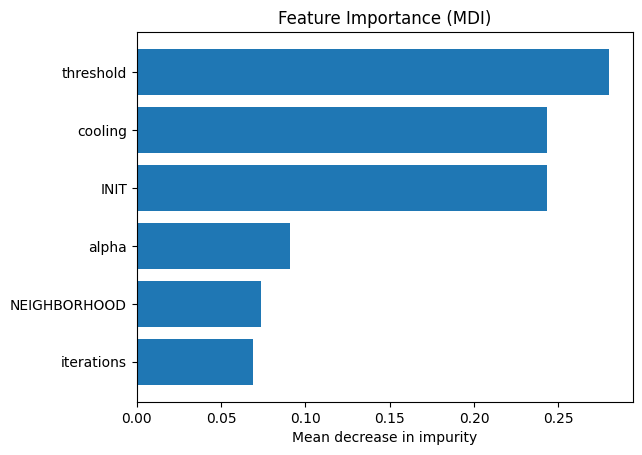

In [17]:
# obtain feature importance
feature_importance = reg.feature_importances_

# sort features according to importance
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0])

# plot feature importances
plt.barh(pos, feature_importance[sorted_idx], align="center")

plt.yticks(pos, np.array(feature_names)[sorted_idx])
plt.title("Feature Importance (MDI)")
plt.xlabel("Mean decrease in impurity");

In [18]:
for name, importance in zip(feature_names, feature_importance):
  print(f"{name}: {importance}")

threshold: 0.28003694878633106
alpha: 0.09113296586087717
iterations: 0.06886155104471138
cooling: 0.2433312931950862
INIT: 0.2431090237935439
NEIGHBORHOOD: 0.07352821731945038


### Exercise 2: Neighborhood definitions

In [19]:
# import libaries
import numpy as np
import math
import random

a) Warehouse location problem

In [20]:
def calc_total_warehouse_cost(demands, costs, fixed_costs, quantities):
  num_sources = len(fixed_costs)
  num_sinks = len(demands)
  cost = 0
  for source in range(num_sources):
    source_used = False
    for sink in range(num_sinks):
      if quantities[source, sink] > 0:
        cost += quantities[source, sink] * costs[source][sink]
        if not source_used:
          source_used = True
          cost += fixed_costs[source]
  return cost

def compute_init_column_minimum(demands, costs, fixed_costs):
  num_sources = len(fixed_costs)
  num_sinks = len(demands)
  quantities = np.zeros((num_sources,num_sinks))
  source_used = [0 for _ in range(num_sources)]
  for sink in range(num_sinks):
    best_source = None
    best_cost_source = None
    for source in range(num_sources):
      cost_source = (1-source_used[source])*fixed_costs[source] + demands[sink]*costs[source][sink]
      if best_cost_source is None or cost_source < best_cost_source:
        best_cost_source = cost_source
        best_source = source
    source_used[best_source] = 1
    quantities[best_source, sink] = demands[sink]
  cost = calc_total_warehouse_cost(demands, costs, fixed_costs, quantities)
  return quantities, cost

def compute_init_random_source(demands, costs, fixed_costs):
  num_sources = len(fixed_costs)
  num_sinks = len(demands)
  quantities = np.zeros((num_sources,num_sinks))
  for sink in range(num_sinks):
    source = random.randrange(num_sources)
    quantities[source, sink] = demands[sink]
  cost = calc_total_warehouse_cost(demands, costs, fixed_costs, quantities)
  return quantities, cost

In [21]:
def warehouse_location_iterations(demands, costs, fixed_costs, iterations, temperature, quantities, cost, step, best_quantities, best_cost, best_step):
  num_sources = len(fixed_costs)
  num_sinks = len(demands)
  for m in range(iterations):
    sink = random.randrange(num_sinks)
    source = random.randrange(num_sources)
    quantities_new = np.copy(quantities)
    quantities_new[:, sink] = np.zeros((num_sources,))
    quantities_new[source, sink] = demands[sink]
    cost_new = calc_total_warehouse_cost(demands, costs, fixed_costs, quantities_new)
    delta = cost - cost_new
    if delta > 0 or (random.random() < math.exp(delta / temperature)):
      quantities, cost = quantities_new, cost_new
    if cost < best_cost:
      best_cost = cost
      best_quantities = quantities
      best_step = step+1
  return quantities, cost, best_quantities, best_cost, best_step

def warehouse_location(demands, costs, fixed_costs, mode_init, alpha=0.1, threshold=100, iterations=100, cooling_parameter=0.95):
  num_sources = len(fixed_costs)
  num_sinks = len(demands)
  if mode_init == 'random':
    quantities, cost = compute_init_random_source(demands, costs, fixed_costs)
  elif mode_init == 'column_min':
    quantities, cost = compute_init_column_minimum(demands, costs, fixed_costs)
  print(quantities)
  print(cost)
  best_step = 0
  best_cost = cost
  best_quantities = quantities
  temperature = cost * alpha
  steps_until_threshold = 0
  quantities_history = [quantities]
  cost_history = [cost]
  temperature_history = [temperature]
  for step in range(threshold):
    quantities, cost, best_quantities, best_cost, best_step = warehouse_location_iterations(demands, costs, fixed_costs, iterations, temperature, quantities, cost, step, best_quantities, best_cost, best_step)
    quantities_history.append(quantities.copy())
    cost_history.append(cost)
    temperature_history.append(temperature)
    temperature = cooling_parameter * temperature
    steps_until_threshold += 1
  print(best_quantities)
  print(best_cost)

In [22]:
costs = [[1,2,10,9,6,7,3],[2,9,0,7,3,6,10],[7,6,1,5,3,10,5],[6,5,10,2,6,3,6],[6,4,6,3,7,2,6]]
fixed_costs = [5,7,5,6,5]
demands = [3,6,6,5,1,2,5]

In [23]:
warehouse_location(demands=demands, costs=costs, fixed_costs=fixed_costs, mode_init='random')

[[0. 0. 0. 0. 0. 0. 0.]
 [3. 0. 0. 5. 1. 0. 5.]
 [0. 6. 0. 0. 0. 0. 0.]
 [0. 0. 6. 0. 0. 2. 0.]
 [0. 0. 0. 0. 0. 0. 0.]]
214.0
[[3. 6. 0. 0. 0. 0. 5.]
 [0. 0. 6. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 5. 0. 2. 0.]
 [0. 0. 0. 0. 0. 0. 0.]]
67.0


In [24]:
warehouse_location(demands=demands, costs=costs, fixed_costs=fixed_costs, mode_init='column_min')

[[3. 6. 0. 0. 0. 0. 5.]
 [0. 0. 6. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 5. 0. 2. 0.]
 [0. 0. 0. 0. 0. 0. 0.]]
67.0
[[3. 6. 0. 0. 0. 0. 5.]
 [0. 0. 6. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 5. 0. 2. 0.]
 [0. 0. 0. 0. 0. 0. 0.]]
67.0


b) Vehicle routing problem

In [25]:
def get_tour_cost(tour, d):
  n_cities = len(tour)
  if n_cities == 0:
    return 0
  cost = d[0][tour[0]] + d[tour[n_cities-1]][0]
  for i in range(1, n_cities):
    u = tour[i-1]
    v = tour[i]
    cost += d[u][v]
  return cost

def vrp_improve(tour_idx_1, tour_1, tour_idx_2, tour_2, pop_start, push_start, d, Q, T, tours):
  if tour_idx_1 == tour_idx_2:
    return None, None
  cost_old = get_tour_cost(tour_1, d) + get_tour_cost(tour_2, d)
  tour_1_new = []
  tour_2_new = []
  n_cities_1 = len(tour_1)
  n_cities_2 = len(tour_2)
  pivot_city_index = 0 if pop_start else n_cities_1-1
  pivot_city = tour_1[pivot_city_index]
  for city in tour_1:
    if city != pivot_city:
      tour_1_new.append(city)
  if push_start:
    tour_2_new.append(pivot_city)
  for city in tour_2:
    tour_2_new.append(city)
  if not push_start:
    tour_2_new.append(pivot_city)
  if max(len(tour_1_new), len(tour_2_new)) > Q:
    return None, None
  cost_new_1 = get_tour_cost(tour_1_new, d)
  cost_new_2 = get_tour_cost(tour_2_new, d)
  if max(cost_new_1, cost_new_2) > T:
    return None, None
  cost_new = cost_new_1 + cost_new_2
  tours_new = []
  for tour_idx, tour in enumerate(tours):
    if tour_idx != tour_idx_1 and tour_idx != tour_idx_2:
      tours_new.append(tour)
    elif tour_idx_1 == tour_idx:
      if tour_1_new:
        tours_new.append(tour_1_new)
    elif tour_idx_2 == tour_idx:
      if tour_2_new:
        tours_new.append(tour_2_new)
  delta = cost_old - cost_new
  return tours_new, delta

def vrp_savings_method_iterations(d, Q, T, iterations, temperature, tours, cost, step, best_tours, best_cost, best_step):
  for m in range(iterations):
    n_tours = len(tours)
    tour_idx_1 = random.randrange(n_tours)
    tour_1 = tours[tour_idx_1]
    tour_idx_2 = random.randrange(n_tours)
    tour_2 = tours[tour_idx_2]
    pop_start = True if random.random() < 0.5 else False
    push_start = True if random.random() < 0.5 else False
    tours_new, delta = vrp_improve(tour_idx_1, tour_1, tour_idx_2, tour_2, pop_start, push_start, d, Q, T, tours)
    if tours_new is not None:
      cost_new = cost - delta
      if delta > 0 or (random.random() < math.exp(delta / temperature)):
        tours, cost = tours_new, cost_new
      if cost < best_cost:
        best_cost = cost
        best_tours = tours
        best_step = step+1
  return tours, cost, best_tours, best_cost, best_step

def vrp_savings_method(d, Q=4, T=16, alpha=0.1, threshold=100, iterations=100, cooling_parameter=0.95):
  n = len(d)-1
  tours = []
  cost = 0
  for i in range(1,n+1):
    cost += d[0][i] + d[i][0]
    tours.append([i])
  print(tours)
  print(cost)
  best_step = 0
  best_cost = cost
  best_tours = tours
  temperature = cost * alpha
  steps_until_threshold = 0
  tours_history = [tours]
  cost_history = [cost]
  temperature_history = [temperature]
  for step in range(threshold):
    tours, cost, best_tours, best_cost, best_step = vrp_savings_method_iterations(d, Q, T, iterations, temperature, tours, cost, step, best_tours, best_cost, best_step)
    tours_history.append(tours.copy())
    cost_history.append(cost)
    temperature_history.append(temperature)
    temperature = cooling_parameter * temperature
    steps_until_threshold += 1
  print(best_tours)
  print(best_cost)

In [26]:
BIG_COST = 1000000
coordinates = [[0, 0], [4, 1], [1, 2], [0, 5], [-3, 3], [-2, 1], [-5, 1], [-5, -1], [-1, -3], [3, -2], [6, -1]]
num_cities = len(coordinates)
d = []
for i, source in enumerate(coordinates):
  d_src = []
  for j, sink in enumerate(coordinates):
    if i == j:
      d_src.append(BIG_COST)
    else:
      d_x = source[0]-sink[0]
      d_y = source[1]-sink[1]
      d_src.append(math.sqrt(d_x*d_x+d_y*d_y))
  d.append(d_src)
  print(d_src)

[1000000, 4.123105625617661, 2.23606797749979, 5.0, 4.242640687119285, 2.23606797749979, 5.0990195135927845, 5.0990195135927845, 3.1622776601683795, 3.605551275463989, 6.082762530298219]
[4.123105625617661, 1000000, 3.1622776601683795, 5.656854249492381, 7.280109889280518, 6.0, 9.0, 9.219544457292887, 6.4031242374328485, 3.1622776601683795, 2.8284271247461903]
[2.23606797749979, 3.1622776601683795, 1000000, 3.1622776601683795, 4.123105625617661, 3.1622776601683795, 6.082762530298219, 6.708203932499369, 5.385164807134504, 4.47213595499958, 5.830951894845301]
[5.0, 5.656854249492381, 3.1622776601683795, 1000000, 3.605551275463989, 4.47213595499958, 6.4031242374328485, 7.810249675906654, 8.06225774829855, 7.615773105863909, 8.48528137423857]
[4.242640687119285, 7.280109889280518, 4.123105625617661, 3.605551275463989, 1000000, 2.23606797749979, 2.8284271247461903, 4.47213595499958, 6.324555320336759, 7.810249675906654, 9.848857801796104]
[2.23606797749979, 6.0, 3.1622776601683795, 4.472135

In [27]:
vrp_savings_method(d)

[[1], [2], [3], [4], [5], [6], [7], [8], [9], [10]]
81.77302552170536
[[2, 3, 4], [5, 6, 7, 8], [9, 10, 1]]
41.83638087891541


### Exercise 3: Tabu Search 

In [28]:
def tabu_search(distance, tour, length, num_cities, tabu_size, max_iterations,neighborhood):
    '''
    Perform Tabu Search to optimize the given tour.

    tour (list): The initial tour.
    length (float): The total length of the initial tour.
    distance (ndarray): The distance matrix that represents the distances between each pair of cities.
    num_cities (int): The number of cities.
    tabu_size (int): The maximum size of the tabu list (default is 25).
    max_iterations (int): The maximum number of iterations for the Tabu Search (default is 1000).

    Returns:
    best_tour (list): The best tour found by the Tabu Search.
    best_length (float): The total length of the best tour.
    '''
    best_length = length  # Initialize the best solution found so far
    best_tour = tour  # Initialize the best tour found so far
    tabu = []  # Initialize the tabu list
    
    # Initialize lists to keep track of the tour and its length at each step
    tour_history = [list(tour)]
    length_history = [length]
    tabu_history=[]
    # Perform the Tabu Search
    for iter_id in range(max_iterations):
        max_improvement = -length
        for i in range(num_cities - 2):
            for j in range(i + 2, num_cities):
                if [i, j] not in tabu:
                    # Calculate the change in the total length of the tour if the two cities are swapped
                    if neighborhood == '2-opt':
                        delta = calculate_delta_with_2opt(distance, tour, i, j)
                    elif neighborhood == 'exchange':
                        delta = calculate_delta_with_exchange(distance, tour, i, j)
                    else:
                        raise ValueError(f"Unknown neighborhood search strategy {neighborhood}")

                    if delta > max_improvement:
                        best_i, best_j = i, j
                        max_improvement = delta

        # Generate a new tour by swapping the two cities
        if neighborhood == '2-opt':
            tour, length = update_tour_with_2opt(tour, best_i, best_j, distance)
        elif neighborhood == 'exchange':
            tour, length = update_tour_with_exchange(tour, best_i, best_j, distance)
        else:
            raise ValueError(f"Unknown neighborhood search strategy {neighborhood}")
        # Append the new tour and its length to the history lists
        tour_history.append(list(tour))
        length_history.append(length)
        tabu_history.append(list(tabu))
        
        
        # Update the tabu list
        tabu.append([best_i, best_j])
        if len(tabu) > tabu_size:
            tabu.pop(0)
        

        # Update the best solution found so far
        if length < best_length:
            best_length = length
            best_tour = tour
            best_iteration = iter_id


    return best_tour, best_length, tour_history, length_history, tabu_history, best_iteration


'''
Calculate Delta
'''

# Function to calculate the change in distance if two cities are swapped according to 2-opt
def calculate_delta_with_2opt(distance, tour, i, j):
    '''
    Function to calculate the change in total tour length if two cities are swapped in 2-opt approach.
    
    Parameters:
    distance (np.array): The distance matrix representing the distances between each pair of cities.
    tour (list): The current tour.
    i (int), j (int): The indices of the two cities to be swapped. Take note that the indices in the code differ from the 
                      nomenclature given in the lecture slides. On page 95 we have the example 1-3-5-2-4-6-8-7-1. The operation
                      2-opt(5,8) leads to the tour 1-3-5-2-4-7-8-6-1. Here the indices refer to the arches and we start indexing 
                      with 1. In this nomenclature index "1" refers to the arch "1-3", index "5"  to arch "4-6" and "8" to the 
                      arch "7-1". 
                      However, in the code this swap is performed when i==4 anf j==7.
                      So, here we are indexing the order of the cities in the (initial) tour starting with 0 (Python convention)
                      whereas in the lecture we index the arches starting with 1.
    '''

    # Calculate the change in the total length of the tour if the two cities are swapped
    # Take note that delta is defined  as Δ=F(new)-F(old) in the lecture slides, so a shorter tour length leads to Δ<0 whereas
    # below it is defined as Δ=F(old)-F(new). 
    delta = distance[tour[i], tour[i + 1]] + distance[tour[j], tour[j + 1]] - distance[tour[i], tour[j]] - distance[tour[i + 1], tour[j + 1]]
    # The loop below calculates the change in total distance for cities between i and j (exclusive) due to swapping.
    # This is needed because when two cities are swapped, it affects the cities between them as well (if dist(a,b)!=dist(b,a)). 
    # They now have different neighboring cities, and this change also contributes to the total tour distance.
    for k in range(j - i - 1):
        # delta is unchanged if the distance matrix is symmetric <==> distance=distance^T
        delta = delta + distance[tour[j - k - 1], tour[j - k]] - distance[tour[j - k], tour[j - k - 1]]  
    
    return delta


 
def calculate_delta_with_exchange(distance, tour, i, j):
    '''
    Function to calculate the change in total tour length if two cities are swapped in exchange approach.
    
    Parameters:
    distance (np.array): The distance matrix representing the distances between each pair of cities.
    tour (list): The current tour.
    i, j (int): The indices of the two cities to be swapped.

    Returns:
    delta (float): The change in total length of the tour if the two cities are swapped.
    '''
    # Calculate old and new lengths
    old_length=calculate_tour_length(tour, distance)
    tour_new, new_length=update_tour_with_exchange(tour, i, j, distance)

    delta = old_length - new_length

    # Return the calculated change in total length
    return delta

def update_tour_with_2opt(tour, i, j, distance):
    '''
    Function to generate a new tour using the 2-opt algorithm.
    
    Parameters:
    tour (list): The current tour.
    i (int), j (int): The indices of the two edges to be swapped.
    delta (float): The change in the total length of the tour if the two edges are swapped.
    length (float): The total length of the current tour.

    Returns:
    tour (list): The optimized tour.
    length (float): The total length of the optimized tour.
    '''
    
    # Generate a new tour by reversing the order of the cities between the two edges
    tour_new = tour[:i + 1] + tour[j:i:-1] + tour[j + 1:]
    
    # Update the total length of the tour
    length_new = calculate_tour_length(tour_new, distance)
    
    # Return the optimized tour and its length
    return tour_new, length_new


def update_tour_with_exchange(tour, i, j, distance):
    '''
    Function to generate a new tour using the exchange neighborhood.
    
    Parameters:
    tour (list): The current tour.
    i (int), j (int): The indices of the two cities to be swapped.
    delta (float): The change in the total length of the tour if the two cities are swapped.
    length (float): The total length of the current tour.

    Returns:
    tour (list): The optimized tour.
    length (float): The total length of the optimized tour.
    '''
    
    # Swap the positions of the two cities in the tour
    tour_new = tour.copy()
    tour_new[i], tour_new[j] = tour[j], tour[i]
    
    # Update the total length of the tour
    length_new = calculate_tour_length(tour_new, distance)
    
    # Return the optimized tour and its length
    return tour_new, length_new



def calculate_tour_length(tour, distance):
    '''
    Function to calculate the total length of a tour.

    Parameters:
    tour (list): The tour, represented as a list of city indices.
    distance (np.array): The distance matrix, representing the distances between each pair of cities.

    Returns:
    length (float): The total length of the tour.
    '''
    
    # Initialize the total length of the tour
    length = 0.0
    
    # Iterate over each city in the tour (excluding the last city, which is the same as the first)
    for i in range(len(tour) - 1):
        # Add the distance from the current city to the next city
        length += distance[tour[i], tour[i + 1]]
    
    # Return the total length of the tour
    return length

In [29]:

'''
Tour Initialization Functions
'''

def compute_nearest_neighbor_tour(distance, num_cities):
    '''
    Function to compute a tour using the nearest neighbor heuristic.
    
    Parameters:
    distance (np.array): Distance matrix representing the distances between each pair of cities.
    num_cities (int): Total number of cities.

    Returns:
    tour (list): The computed tour as a list of city indices.
    length (float): Total length of the tour.
    '''
    position = 0  
    tour = [0]  
    length = 0  

    # Iterate over all cities and find the nearest city that is not already in the tour
    for i in range(num_cities - 1):
        closest_city = 0  
        min_distance = float('inf')  

        # Find the nearest city not already in the tour
        for j in range(num_cities):
            if (j not in tour) and (distance[position, j] < min_distance):
                min_distance = distance[position, j]
                closest_city = j
                
        tour.append(closest_city)  
        length += min_distance  
        position = closest_city  

    # Close the tour by returning to the first city and add the distance to the total length
    tour.append(0)
    length += distance[position, 0]
    
    return tour, length


In [30]:
# Set parameters


# The path to the data file
PATH = 'gr120.xlsx'

# MODE can be "DistanceMatrix" or "Coordinates" depending on whether your data is a distance matrix 
# or a set of geographical coordinates, respectively.
MODE = "DistanceMatrix"


# INIT specifies the method for generating the initial tour. Options are:
# "nearest_neighbor" - selects the next city that is the nearest unvisited neighbor
# "successive_insertion" - selects the next city that results in the least increase in tour length
# "random" - selects the next city randomly


# NEIGHBORHOOD specifies the neighborhood search strategy. Options are:
# "2-opt" - repeatedly removes two edges and replaces them in a way that reduces the tour length
# "exchange" - swaps the positions of two cities in the tour

parameters = {'TABU_SIZE': [0, 5, 25, 50, 100],
              'NEIGHBORHOOD':['2-opt','exchange']}
"""
parameters = {'TABU_SIZE': [0, 5],
              'NEIGHBORHOOD':['2-opt','exchange']}
"""
# The code will compute the tour and its length for all possible combinations of parameters given in the 'parameters' dictionary.
# Each parameter will take on its possible values, resulting in a set of unique parameter combinations.
# The number of tours will be equal to the product of the number of possible values for each parameter.
# The tour and its length will be computed for each parameter combination using the defined algorithm.

MAX_ITERATIONS = 100

# Compute the distance matrix
distance = compute_distance_matrix(MODE, PATH)

# Get the number of cities
num_cities = len(distance)

# Generate all combinations of parameter values
param_values = list(itertools.product(*parameters.values()))

performance_dict = {}
N = len(param_values)
n = 0

for values in param_values:
    # Convert the tuple of values to a dictionary
    params_dict = {k: v for k, v in zip(parameters.keys(), values)}

    params_str = ', '.join(f'{k}:{v}' for k, v in params_dict.items())
    print(f"{n+1}/{N}  -  {params_str}")
    print(params_str)

    tour, length = compute_nearest_neighbor_tour(distance, num_cities)
    
    init_tour = tour 
    init_length = length
    start = time.time()
    best_tour, best_tour_length, tour_history, length_history, tabu_history, best_iteration = tabu_search(distance, init_tour, init_length, num_cities, params_dict['TABU_SIZE'], MAX_ITERATIONS, params_dict['NEIGHBORHOOD'])
    end = time.time()
    
    # Store all the parameters and results in the dictionary
    performance_dict[n] = {**params_dict, 'best_tour_length': best_tour_length, 'time': round(end - start, 4), 'best_tour': best_tour, 'tour_history': tour_history, 'length_history': length_history, 'tabu_history': tabu_history, 'best_iteration':best_iteration}
    
    n += 1
    if (n + 1) < 10:
        print(f"         Time: {round(end - start, 4)} s")
    else:
        print(f"          Time: {round(end - start, 4)} s")


1/10  -  TABU_SIZE:0, NEIGHBORHOOD:2-opt
TABU_SIZE:0, NEIGHBORHOOD:2-opt
         Time: 19.0532 s
2/10  -  TABU_SIZE:0, NEIGHBORHOOD:exchange
TABU_SIZE:0, NEIGHBORHOOD:exchange
         Time: 66.2114 s
3/10  -  TABU_SIZE:5, NEIGHBORHOOD:2-opt
TABU_SIZE:5, NEIGHBORHOOD:2-opt
         Time: 19.4477 s
4/10  -  TABU_SIZE:5, NEIGHBORHOOD:exchange
TABU_SIZE:5, NEIGHBORHOOD:exchange
         Time: 65.6044 s
5/10  -  TABU_SIZE:25, NEIGHBORHOOD:2-opt
TABU_SIZE:25, NEIGHBORHOOD:2-opt
         Time: 17.9462 s
6/10  -  TABU_SIZE:25, NEIGHBORHOOD:exchange
TABU_SIZE:25, NEIGHBORHOOD:exchange
         Time: 65.8076 s
7/10  -  TABU_SIZE:50, NEIGHBORHOOD:2-opt
TABU_SIZE:50, NEIGHBORHOOD:2-opt
         Time: 19.6757 s
8/10  -  TABU_SIZE:50, NEIGHBORHOOD:exchange
TABU_SIZE:50, NEIGHBORHOOD:exchange
         Time: 65.5576 s
9/10  -  TABU_SIZE:100, NEIGHBORHOOD:2-opt
TABU_SIZE:100, NEIGHBORHOOD:2-opt
          Time: 18.2881 s
10/10  -  TABU_SIZE:100, NEIGHBORHOOD:exchange
TABU_SIZE:100, NEIGHBORHOOD:exchan

In [31]:
def pretty_print(df):
    """
    Applies styling to a DataFrame and displays it with improved formatting.

    Inputs:
    - df (pandas.DataFrame): The DataFrame to be displayed.

    Returns:
    - None
    """
    return display(HTML(df.to_html().replace("\\n","<br>")))

In [32]:
performance_dict_short = {}
for key, value in performance_dict.items():
    performance_dict_short[key] = {k: v for k, v in value.items() if k not in ['best_tour', 'tour_history', 'length_history', 'tabu_history']}
summary_performance = pd.DataFrame.from_dict(performance_dict_short, orient='index')
summary_performance.rename(columns={'best_tour_length': 'Objective', 'time': 'Time [s]'}, inplace=True)

# Apply styling to DataFrame
styled = summary_performance.style.set_properties(**{'background-color': 'black',
                                                    'color': 'lawngreen',
                                                    'border-color': 'white'})

pretty_print(styled)


,TABU_SIZE,NEIGHBORHOOD,Objective,Time [s],best_iteration
0,0,2-opt,7231.000000,19.053200,29
1,0,exchange,9025.000000,66.211400,6
2,5,2-opt,7231.000000,19.447700,29
3,5,exchange,8925.000000,65.604400,29
4,25,2-opt,7124.000000,17.946200,64
5,25,exchange,8910.000000,65.807600,62
6,50,2-opt,7117.000000,19.675700,73
7,50,exchange,8928.000000,65.557600,10
8,100,2-opt,7117.000000,18.288100,73
9,100,exchange,8716.000000,66.607900,92


In [33]:
def plot_tours(N, step, max_steps_dict, **kwargs):
    '''
    Plots the TSP tours and the tour length as a function of the step.

    Inputs:
    - N (int): The total number of tours.
    - step (int): The current step for which the tour is being plotted.
    - max_steps_dict (dict): A dictionary mapping parameter set indices to their respective maximum number of steps.
    - **kwargs: Parameters which define a particular tour.

    Outputs:
    - Two plots: one visualizing the tour path and the other displaying the tour length over time.
    '''    
    # Calculate tour_index from parameter values
    tour_index =  get_index_from_parameters(kwargs)

    # Get the maximum number of steps for the current parameter set
    max_steps = max_steps_dict[tour_index]
    
    # Calculate tour_index from parameter values
    tour_index = tour_index = get_index_from_parameters(kwargs)

    fig, ax = plt.subplots(figsize=(8, 8))

    # Plot all cities
    ax.scatter(coordinates[:, 0], coordinates[:, 1], color='black', s=10)

    # Annotate the city numbers
    for i, txt in enumerate(coordinates):
        ax.annotate(i, (coordinates[i, 0], coordinates[i, 1]), fontsize=8, ha='right')

    # Define a color map
    colors = plt.cm.get_cmap('rainbow', N)

    # Plot tours
    tour_history = performance_dict[tour_index]['tour_history']
    if step < max_steps: #len(tour_history):  # Check if the step is within the history length
        tour = tour_history[step]
        tour_coords = coordinates[tour]
        tour_coords = np.vstack((tour_coords, tour_coords[0]))  # Close the tour
        color = colors(tour_index)
        ax.plot(tour_coords[:, 0], tour_coords[:, 1], color=color)
        # Save the color of the plotted tour
        #color_dict[tour_index] = color

    # Add parameters and tour length as labels in the plot
    ax.text(0.01, 0.98, f'tour length at step {step}/{max_steps-1}: {performance_dict[tour_index]["length_history"][step]}', transform=ax.transAxes, fontsize=8, va='top', ha='left')
    for i, (k, v) in enumerate(kwargs.items()):
        if k == "steps":
            continue  # Skip 'steps' because it's already in the tour length label
        ax.text(0.01, 0.98-(i+2)*0.025, f'{k}: {v}', transform=ax.transAxes, fontsize=8, va='top', ha='left')

    ax.grid(True)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title('TSP Tours', fontsize=16)
    plt.show()
    
    best_tour = performance_dict[tour_index]['best_tour']
    best_iteration = performance_dict[tour_index]['best_iteration']
    tour_lengths = performance_dict[tour_index]['length_history']
    
    print('Best tour length: '+ str(min(tour_lengths)))
    print('Best iteration: '+ str(best_iteration))
    print('Best tour: ', best_tour )
    print('Tour: ', tour )
    
    # Plot the tour length as a function of step
    plt.figure(figsize=(8, 4))
    tour_lengths = performance_dict[tour_index]['length_history']
    plt.plot(tour_lengths, '-',color=colors(tour_index))  # +1 because the slice excludes the last index

    # Annotate initial and final distances
    initial_distance = tour_lengths[0]
    final_distance = tour_lengths[-1]

    plt.annotate(f'{initial_distance}', (0, initial_distance), 
                 textcoords="offset points", xytext=(-5,10), ha='center',color='k')
    plt.annotate(f' {final_distance}', (len(tour_lengths)-1, final_distance), 
                 textcoords="offset points", xytext=(-10,10), ha='center',color='k')

    plt.xlabel('Step')
    plt.ylabel('Tour length')
    plt.ylim(0,1.05*max(max(value['length_history']) for value in performance_dict.values()))
    plt.title('Tour length as a function of step')
    plt.grid(True)
    plt.show()
    
# Create a callback function to update the 'step' Slider widget
def update_step_range(*args):
    """
    Callback function to update the maximum value of the 'step' Slider widget based on the selected value of the 'steps' Select widget.

    Inputs:
    - *args: Variable length argument list.

    Returns:
    - None
    """
    selects['step'].max = selects['steps'].value - 1

In [34]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [35]:
# Define a dictionary to store the maximum number of steps for each parameter set
max_steps_dict = {}

# Load coordinates
coordinates = get_coordinates(PATH)

# Define parameters and their possible values
weights = np.cumprod([1] + [len(v) for v in list(parameters.values())[:-1]])

# Define a color map
colors = plt.cm.get_cmap('rainbow', N)

# Create Select widgets for selecting parameters
param_selects = {k: widgets.Select(options=v, description=k) for k, v in parameters.items()}

# Find the maximum steps from performance_dict
max_steps_total = MAX_ITERATIONS
color_dict=get_tour_colors(N)

# Add a slider for the steps
step_slider = widgets.IntSlider(min=0, max=max_steps_total, description='step')

# Combine all widgets
selects = {**param_selects, 'step': step_slider}

def get_index_from_parameters(params_dict):
    """
    Calculate the index in the performance_dict based on the selected parameters.
    """
    index = 0
    for i, k in enumerate(parameters.keys()):
        # Calculate the product of the lengths of all subsequent parameters
        weight = np.prod([len(parameters[k]) for k in list(parameters.keys())[i+1:]])
        # Add the product of the index of the selected value and the weight to the total index
        index += parameters[k].index(params_dict[k]) * weight
    return index


def update_step_range(*args):
    """
    Update the range of the 'step' Slider widget based on the selected parameter values.
    """
    # Determine the index of the current parameter combination
    params_dict = {k: v.value for k, v in param_selects.items()}  # Changed from selects to param_selects
    index = get_index_from_parameters(params_dict)
    # Get the 'steps_to_threshold' of the current parameter combination
    max_steps = MAX_ITERATIONS

    # Update the maximum value and value of the 'step' Slider
    step_slider.max = max_steps  # Changed from selects['step'] to step_slider
    step_slider.value = max_steps - 1  # Always set value to maximum step - 1

    # Store the maximum number of steps for the current parameter set
    max_steps_dict[index] = max_steps

# Populate max_steps_dict and initialize 'step' Slider's max and value
for param_set, record in performance_dict.items():
    max_steps_dict[param_set] = MAX_ITERATIONS-1

# Only call update_step_range when a param_select widget's value changes
for select in param_selects.values():
    select.observe(update_step_range, names='value', type='change')

# Initialize 'step' Slider's max and value to correspond to the first parameter set
first_param_set_index = get_index_from_parameters({k: v.options[0] for k, v in param_selects.items()})  # Changed from selects to param_selects
step_slider.max = max_steps_dict[first_param_set_index]-1  # Changed from selects['step'] to step_slider
step_slider.value = step_slider.max # - 1  # Initialize to maximum step - 1

# Create interactive plot
interactive_plot = widgets.interactive_output(
    plot_tours,
    {**param_selects, 'step': step_slider, 'N': widgets.fixed(N), 'max_steps_dict': widgets.fixed(max_steps_dict)}  # Changed from selects to param_selects and selects['step'] to step_slider
)

box_layout = Layout(display='flex',
                    flex_flow='row wrap',
                    align_items='stretch',
                    width='auto',
                    overflow='scroll')  # Set overflow to 'scroll'

# Display selects and plot
display(widgets.VBox(list(selects.values()),layout=box_layout))
display(interactive_plot)



<ipython-input-35-29b3737a4774>:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('rainbow', N)
<ipython-input-8-48f36d66166a>:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('rainbow', N)  # Color map


Output()

In [36]:
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import HoverTool
from bokeh import colors
from bokeh.colors import RGB
from bokeh.palettes import Category20
from bokeh.models import LogAxis, SingleIntervalTicker
from bokeh.models import NumeralTickFormatter
from bokeh.models.tickers import LogTicker

In [37]:
def plot_tour_length_bokeh(tour_index):
  output_notebook()
  p = figure(width=400, height=400)
  tour_lengths = performance_dict[tour_index]['length_history']
  n_tour_lengths = len(tour_lengths)
  x = list(range(n_tour_lengths))
  y = tour_lengths
  p.line(x, y, line_width=2)
  show(p)

In [38]:
for tour_index, hyperparams in performance_dict_short.items():
  print(hyperparams)
  plot_tour_length_bokeh(tour_index)

{'TABU_SIZE': 0, 'NEIGHBORHOOD': '2-opt', 'best_tour_length': 7231.0, 'time': 19.0532, 'best_iteration': 29}


{'TABU_SIZE': 0, 'NEIGHBORHOOD': 'exchange', 'best_tour_length': 9025.0, 'time': 66.2114, 'best_iteration': 6}


{'TABU_SIZE': 5, 'NEIGHBORHOOD': '2-opt', 'best_tour_length': 7231.0, 'time': 19.4477, 'best_iteration': 29}


{'TABU_SIZE': 5, 'NEIGHBORHOOD': 'exchange', 'best_tour_length': 8925.0, 'time': 65.6044, 'best_iteration': 29}


{'TABU_SIZE': 25, 'NEIGHBORHOOD': '2-opt', 'best_tour_length': 7124.0, 'time': 17.9462, 'best_iteration': 64}


{'TABU_SIZE': 25, 'NEIGHBORHOOD': 'exchange', 'best_tour_length': 8910.0, 'time': 65.8076, 'best_iteration': 62}


{'TABU_SIZE': 50, 'NEIGHBORHOOD': '2-opt', 'best_tour_length': 7117.0, 'time': 19.6757, 'best_iteration': 73}


{'TABU_SIZE': 50, 'NEIGHBORHOOD': 'exchange', 'best_tour_length': 8928.0, 'time': 65.5576, 'best_iteration': 10}


{'TABU_SIZE': 100, 'NEIGHBORHOOD': '2-opt', 'best_tour_length': 7117.0, 'time': 18.2881, 'best_iteration': 73}


{'TABU_SIZE': 100, 'NEIGHBORHOOD': 'exchange', 'best_tour_length': 8716.0, 'time': 66.6079, 'best_iteration': 92}


### Exercise 4: Genetic Algorithm for Capacitated Warehouse Location Problem

In [39]:
import urllib.request
import numpy as np
import random
import pandas as pd

In [40]:
def parse_text_file(data):
    """
    This function parses a text file to extract various warehouse and customer related data.
    
    Arguments:
        data: list of text lines to be parsed

    Returns:
        tuple: A tuple containing the following elements:
            - locations (int): Number of warehouse locations
            - capacity (list): List containing the capacity of each warehouse
            - fixcost (list): List containing the fixed cost of each warehouse
            - varcost (np.array): A 2D numpy array containing the variable cost to serve 
              1 unit of demand from warehouse i to customer j. It's of size (locations, customers).
            - customers (int): Number of customer locations
            - demand (list): List containing the demand of each customer
    """
    
    locations, customers = map(int, data[0].split())
    
    capacity, fixcost = [], []
    for i in range(locations):
        c, f = map(float, data[i+1].split())
        capacity.append(c)
        fixcost.append(f)
    
    demand = []
    varcost = np.zeros((locations, customers))
    for j in range(customers):
        row_step = 1 + int(np.ceil(locations / 7))
        demand.append(float(data[j*row_step + locations + 1].split()[0]))
        
        v = list(np.concatenate([data[j*row_step + locations + 1 + t].split() for t in range(1, row_step)]))
        for i in range(locations):
            # Here we normalize variable cost per unit of demand
            varcost[i,j] = float(v[i]) / demand[j]

    print(f'Locations: {locations}')
    print(f'Capacities: {capacity}')    
    print(f'Customers: {customers}')
    print(f'Demands: {demand}')
    
    return locations, capacity, fixcost, varcost, customers, demand
    
    
    
    
def download_and_load_data(url, filename):
    """
    This function downloads a file from a given URL and reads the content of the file.

    Arguments:
        url (str): The URL from where the file needs to be downloaded.
        filename (str): The name of the file where the downloaded data will be saved.

    Returns:
        list: A list of lines read from the downloaded file.
    """
    import urllib.request

    # Download the file from the specified URL
    urllib.request.urlretrieve(url, filename)

    # Open the file in read mode
    with open(filename, 'r') as file:
        # Read the lines from the file
        data = file.readlines()

    return data

In [41]:
url = 'http://people.brunel.ac.uk/~mastjjb/jeb/orlib/files/cap44.txt'
filename = 'cap44.txt'

In [42]:
data = download_and_load_data(url, filename)

In [43]:
locations, capacity, fixcost, varcost, customers, demand = parse_text_file(data)

Locations: 16
Capacities: [5000.0, 5000.0, 5000.0, 5000.0, 5000.0, 5000.0, 5000.0, 5000.0, 5000.0, 5000.0, 5000.0, 5000.0, 5000.0, 5000.0, 5000.0, 5000.0]
Customers: 50
Demands: [146.0, 87.0, 672.0, 1337.0, 31.0, 559.0, 2370.0, 1089.0, 33.0, 32.0, 5495.0, 904.0, 1466.0, 143.0, 615.0, 564.0, 226.0, 3016.0, 253.0, 195.0, 38.0, 807.0, 551.0, 304.0, 814.0, 337.0, 4368.0, 577.0, 482.0, 495.0, 231.0, 322.0, 685.0, 12912.0, 325.0, 366.0, 3671.0, 2213.0, 705.0, 328.0, 1681.0, 1117.0, 275.0, 500.0, 2241.0, 733.0, 222.0, 49.0, 1464.0, 222.0]


In [44]:
print(f'Fixcosts: {fixcost}')
print(f'Varcosts: {varcost}')

Fixcosts: [25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 0.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0]
Varcosts: [[ 46.1625  36.8375   7.3125  24.2125  55.3375  11.4875  34.5875  30.6625
   61.2375  45.6125  25.6625  19.5625  26.0625  13.6625  27.9375  45.4625
   31.1125  26.0125  37.3625  44.0875  41.6125  28.7125  21.9375  16.0625
   29.5625  12.2375  64.4375  19.1625  17.8125  25.2125  16.1375  14.5125
   19.6375  28.8625  29.9875  32.9375  26.5875  27.4625  77.2625  21.7875
   22.6125  35.5625  58.5875  33.9625  75.2625  77.9125  70.1625  51.8875
   23.2625  31.9625]
 [ 70.925   62.725   39.3     22.425   69.425   42.4     12.025   24.375
   75.175   62.35    37.475   35.475   28.975   35.275   58.625   63.125
   46.425   30.675   49.175   72.375   53.425   60.35    36.075   42.275
   48.75    36.05    93.125   38.325   46.575   51.425   48.125   41.45
   51.25    17.75    55.6     49.675   20.05    28.725   92.45    26.275
   42.075 